<a href="https://colab.research.google.com/github/iemio/torch/blob/main/notebook_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

What Does It Do?
- Mean: (0.5,) → Subtracts 0.5 from each pixel.
- Standard Deviation: (0.5,) → Divides each pixel by 0.5.
ffect on Pixel Values:
If your input images have pixel values in the range [0, 1], this transformation:

Shifts them to [-1, 1] because:
When x = 0: (0 - 0.5) / 0.5 = -1
When x = 1: (1 - 0.5) / 0.5 = 1

In [5]:
dataiter = iter(data_loader)
# images, labels = dataiter.next().  ------->Incorrect
#The method .next() was used in Python 2, but in Python 3, it's replaced by the built-in next(iterator) function.
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [9]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Input [-1, +1] -> use nn.Tanh

In [6]:
class Autoencoder_cnn_01(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [8]:
class Autoencoder_cnn_02(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # N, 16, 28, 28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),  # N, 16, 14, 14

            nn.Conv2d(16, 32, 3, padding=1),  # N, 32, 14, 14
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),  # N, 32, 7, 7

            nn.Conv2d(32, 64, 7),  # N, 64, 1, 1
            nn.ReLU()
        )

        # MaxPool2d requires indices for unpooling
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) #return_indices=True :This is necessary because nn.MaxUnpool2d needs these indices to restore spatial information.
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool1 = nn.MaxUnpool2d(2, stride=2)
        self.unpool2 = nn.MaxUnpool2d(2, stride=2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # N, 32, 7, 7
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, 3, padding=1),  # N, 16, 14, 14
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, 3, padding=1),  # N, 1, 28, 28
            nn.Tanh()  # Output range [-1, 1] as per your note
        )

    def forward(self, x):
        # Encode
        x = self.encoder[0](x)
        x = self.encoder[1](x)
        x, indices1 = self.pool1(x)  # Save indices for unpooling

        x = self.encoder[3](x)
        x = self.encoder[4](x)
        x, indices2 = self.pool2(x)  # Save indices for unpooling

        x = self.encoder[6](x)
        x = self.encoder[7](x)

        # Decode
        x = self.decoder[0](x)
        x = self.decoder[1](x)

        x = self.unpool2(x, indices2)  # Unpool to (N, 32, 14, 14)
        x = self.decoder[2](x)
        x = self.decoder[3](x)

        x = self.unpool1(x, indices1)  # Unpool to (N, 16, 28, 28)
        x = self.decoder[4](x)
        x = self.decoder[5](x)

        return x


In [9]:

model = Autoencoder_cnn_01() #_Linear

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [10]:
# Point to training loop video
num_epochs = 2
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0102
Epoch:2, Loss:0.0068


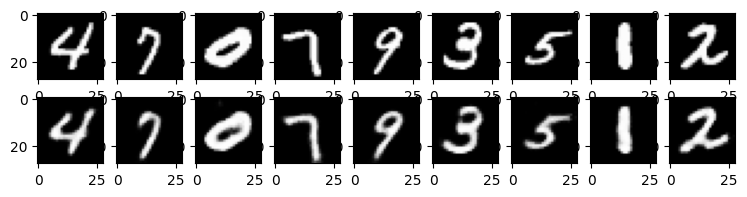

In [11]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

Understanding the Encoded Data (Latent Space)
The encoder reduces a 28×28 image (784 pixels) to 3 values (N, 3).
This means each image is mapped into a 3D space (latent representation).
Since it's only 3 values per image, you cannot directly reshape and plot it as an image.
Instead, you can visualize it as a scatter plot in 3D.

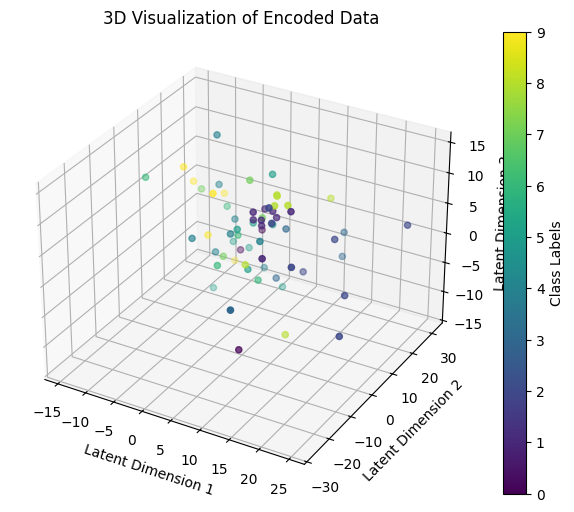

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# Assume you have a batch of images
images, labels = next(iter(data_loader))  # Flatten to (N, 784)

# Get encoded representations
with torch.no_grad():
    encoded_data = model.encoder(images)  # (N, 3)

# Convert to NumPy for plotting
encoded_data = encoded_data.numpy()
labels = labels.numpy()

# 3D Scatter Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], c=labels, cmap='viridis')

# Add labels
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_zlabel("Latent Dimension 3")
plt.colorbar(scatter, label="Class Labels")
plt.title("3D Visualization of Encoded Data")
plt.show()
